IMRT Beam Angle Optimization
==
Usando como base el solver `DAO_ILS`, la idea es crear un algoritmo que permita encontrar los mejores ángulos para realizar el tratamiento.

---
**Carga de librerías y conexión SSH**

In [57]:
import paramiko
import getpass
import numpy as np
import imrt

In [58]:
ssh = imrt.connect("158.251.88.197")

login: iaraya
pass: ········


In [53]:
import importlib
importlib.reload(imrt)

def D(dose_vector, x=95): return dose_vector[int(len(dose_vector)*x/100)]
def Dmax(dose_vector): return np.max(dose_vector)
def Dmean(dose_vector): return np.mean(dose_vector)
def V(dose_vector, dose=0.95*76): return np.argmax(dose_vector < dose)/len(dose_vector)

----
Constructor imrt
---

Se carga la instancia remotamente generando las estructuras necesarias para ser usada. `max_voxels` es la cantidad máxima de voxels que se usa para representar un órgano. Limitar la cantidad permite probar los algoritmos más rápidamente.

Además carga localmente información de las instancias:

* cantidad de voxels por órgano (`nvoxels`)
* lista de ángulos (`angles`)
* cantidad de beamlets y valid shapes por ángulos (`angle2nbeamlets`)

In [17]:
instance = imrt.imrt("/home/iaraya/imrt", ["data/Equidistantes/equidist.txt", "data/Equidistantes/equidist-coord.txt"], ssh, max_voxels=1000, port=8051)

killall DAO_ILS; /home/iaraya/imrt/DAO_ILS --files-dep=data/Equidistantes/equidist.txt --file-coord=data/Equidistantes/equidist-coord.txt --tabu-size=200 --setup=5 --seed=3 --min_impr=0.05 --maxeval=1000 --vsize=0.002 --max_voxels=1000 --path=/home/iaraya/imrt --port=8051
echo start | netcat localhost 8051
ready



In [28]:
instance = imrt.imrt("/home/iaraya/imrt", ["data/TRT00X/TRT003_10b.txt", "data/TRT00X/TRT003-coord.txt"], \
                     ssh, max_voxels=2000000, port=8051, targeted=True, min_impr=0.05, vsize=0.002)

killall DAO_ILS; /home/iaraya/imrt/DAO_ILS --files-dep=data/TRT00X/TRT003_10b.txt --file-coord=data/TRT00X/TRT003-coord.txt --tabu-size=200 --setup=5 --seed=3 --min_impr=0.05 --maxeval=1000 --vsize=0.002 --max_voxels=2000000 --path=/home/iaraya/imrt --port=8051
echo start | netcat localhost 8051
ready



killall DAO_ILS; /home/iaraya/imrt/DAO_ILS --files-dep=data/TRT00X/TRT001_00b.txt --file-coord=data/TRT00X/TRT001-coord.txt --tabu-size=200 --setup=5 --seed=3 --min_impr=0.05 --maxeval=1000 --vsize=0.002 --max_voxels=2000000 --path=/home/iaraya/imrt --port=8051
echo start | netcat localhost 8051
ready

echo init_fluence_map 5 0 70 140 210 280 12 10 8 0 12 12 11 10 10 13 13 12 12 13 13 13 13 11 11 11 11 13 12 12 11 10 10 8 8 11 12 10 10 10 10 8 10 11 11 11 11 11 10 10 13 12 12 12 11 11 11 11 11 11 11 12 12 12 12 8 13 11 11 11 13 12 12 12 13 13 12 5 5 12 12 11 12 12 12 12 12 9 11 11 11 12 12 11 9 9 12 12 12 12 12 12 11 11 11 11 12 12 12 11 11 11 0 8 9 9 12 12 12 11 0 12 12 12 12 0 9 11 11 11 11 9 9 8 12 9 9 5 0 8 12 7 9 7 7 12 12 10 10 10 10 10 10 11 10 10 10 10 10 10 11 12 11 11 11 10 10 9 7 11 10 10 10 10 10 9 9 9 9 9 10 11 10 10 7 7 7 9 10 11 12 9 9 9 10 10 11 9 9 9 10 10 10 11 12 12 12 17 17 11 10 10 9 10 10 12 10 10 10 12 17 10 9 9 9 11 11 11 9 9 9 9 11 10 9 9 9 9 9 9 12 10 10 10 10

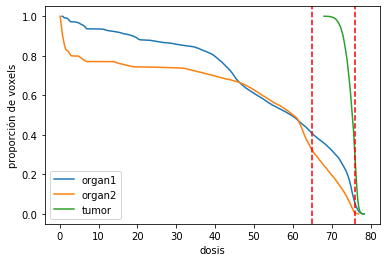

In [55]:
instance = imrt.imrt("/home/iaraya/imrt", ["data/TRT00X/TRT001_00b.txt", "data/TRT00X/TRT001-coord.txt"], ssh, max_voxels=2000000, port=8051, targeted=True)
bac=[0, 70, 140, 210, 280]
val=instance.init_fluence_map(fluence_map=[12,10,8,0,12,12,11,10,10,13,13,12,12,13,13,13,13,11,11,11,11,13,12,12,11,10,10,8,8,11,12,10,10,10,10,8,10,11,11,11,11,11,10,10,13,12,12,12,11,11,11,11,11,11,11,12,12,12,12,8,13,11,11,11,13,12,12,12,13,13,12,5,5,12,12,11,12,12,12,12,12,9,11,11,11,12,12,11,9,9,12,12,12,12,12,12,11,11,11,11,12,12,12,11,11,11,0,8,9,9,12,12,12,11,0,12,12,12,12,0,9,11,11,11,11,9,9,8,12,9,9,5,0,8,12,7,9,7,7,12,12,10,10,10,10,10,10,11,10,10,10,10,10,10,11,12,11,11,11,10,10,9,7,11,10,10,10,10,10,9,9,9,9,9,10,11,10,10,7,7,7,9,10,11,12,9,9,9,10,10,11,9,9,9,10,10,10,11,12,12,12,17,17,11,10,10,9,10,10,12,10,10,10,12,17,10,9,9,9,11,11,11,9,9,9,9,11,10,9,9,9,9,9,9,12,10,10,10,10,10,10,10,17,11,10,10,10,10,10,9,12,10,10,10,10,10,9,9,9,9,9,10,10,12,12,12,12,17,0,0,5,0,5,10,9,0,5,11,10,10,5,10,10,11,11,0,5,5,11,11,10,10,10,5,11,11,11,10,9,8,8,11,10,10,10,10,9,0,0,10,10,10,10,10,5,10,10,11,10,10,5,9,9,11,5,0,0], \
                          bac=bac)
print("z(x)=",val)
print("bac=",bac)
dose_vectors = instance.get_dose_vectors()
#print("D_95 (tumor): ", D(dose_vectors[2],x=95))
#print("Dmax (organ1): ", Dmax(dose_vectors[0]))
#print("Dmean (organ2): ", Dmean(dose_vectors[1]))
#print("V_95 (tumor): ", V(dose_vectors[2], dose=0.99*76))
imrt.show_plot(dose_vectors)

echo init_fluence_map 5 0 70 140 210 280 11 11 14 12 12 12 14 12 12 12 12 14 14 14 11 11 11 11 14 14 14 12 11 11 10 10 14 14 11 11 11 11 10 8 14 12 11 11 11 11 11 8 14 14 12 12 12 12 12 12 14 14 12 12 11 11 12 12 12 12 14 14 12 12 12 14 14 12 12 11 12 12 10 11 11 12 0 11 11 11 11 11 12 11 11 12 11 11 11 11 11 10 10 11 11 11 11 12 11 9 9 9 9 9 12 12 12 11 11 10 11 12 12 12 7 10 10 10 12 9 9 9 11 0 9 9 10 0 11 10 11 11 13 13 11 11 11 11 11 15 13 12 11 11 11 10 10 11 11 13 12 12 11 10 10 10 10 10 10 10 10 10 12 12 11 10 10 10 10 10 10 10 10 10 10 13 10 10 10 10 10 12 10 10 10 10 13 10 10 10 12 15 15 15 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 9 9 9 8 11 10 10 10 10 10 6 11 11 9 9 9 9 9 9 10 10 10 10 11 10 10 10 10 11 11 11 11 10 10 10 10 10 11 10 9 9 11 11 10 9 8 11 11 10 8 11 11 8 0 3 10 10 10 12 13 2 13 14 14 17 12 14 14 14 17 10 10 10 13 14 14 14 17 13 13 13 13 14 13 13 13 17 12 12 12 12 12 10 10 12 12 12 12 13 14 0 10 17 12 12 12 17 14 12 | netcat localhost 8051
58.1697


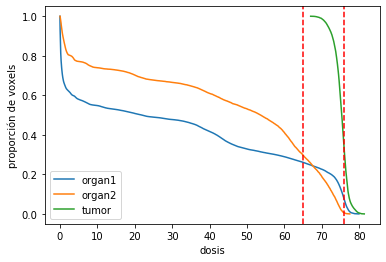

In [47]:
instance = imrt.imrt("/home/iaraya/imrt", ["data/TRT00X/TRT002_00b.txt", "data/TRT00X/TRT002-coord.txt"], ssh, max_voxels=2000000, port=8051, targeted=True)
val=instance.init_fluence_map(fluence_map=[11,11,14,12,12,12,14,12,12,12,12,14,14,14,11,11,11,11,14,14,14,12,11,11,10,10,14,14,11,11,11,11,10,8,14,12,11,11,11,11,11,8,14,14,12,12,12,12,12,12,14,14,12,12,11,11,12,12,12,12,14,14,12,12,12,14,14,12,12,11,12,12,10,11,11,12,0,11,11,11,11,11,12,11,11,12,11,11,11,11,11,10,10,11,11,11,11,12,11,9,9,9,9,9,12,12,12,11,11,10,11,12,12,12,7,10,10,10,12,9,9,9,11,0,9,9,10,0,11,10,11,11,13,13,11,11,11,11,11,15,13,12,11,11,11,10,10,11,11,13,12,12,11,10,10,10,10,10,10,10,10,10,12,12,11,10,10,10,10,10,10,10,10,10,10,13,10,10,10,10,10,12,10,10,10,10,13,10,10,10,12,15,15,15,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,9,9,9,8,11,10,10,10,10,10,6,11,11,9,9,9,9,9,9,10,10,10,10,11,10,10,10,10,11,11,11,11,10,10,10,10,10,11,10,9,9,11,11,10,9,8,11,11,10,8,11,11,8,0,3,10,10,10,12,13,2,13,14,14,17,12,14,14,14,17,10,10,10,13,14,14,14,17,13,13,13,13,14,13,13,13,17,12,12,12,12,12,10,10,12,12,12,12,13,14,0,10,17,12,12,12,17,14,12], \
                          bac=[0, 70, 140, 210, 280])
print(val)
dose_vectors = instance.get_dose_vectors()
imrt.show_plot(dose_vectors)


killall DAO_ILS; /home/iaraya/imrt/DAO_ILS --files-dep=data/TRT00X/TRT004_00b.txt --file-coord=data/TRT00X/TRT004-coord.txt --tabu-size=200 --setup=5 --seed=3 --min_impr=0.05 --maxeval=1000 --vsize=0.002 --max_voxels=2000000 --path=/home/iaraya/imrt --port=8051
echo start | netcat localhost 8051
ready

echo init_fluence_map 5 0 70 140 210 280 14 14 19 14 14 14 14 20 14 14 14 14 20 14 14 16 16 20 16 16 16 16 20 17 17 17 17 20 16 16 17 17 20 16 17 14 10 0 7 7 5 8 8 8 8 6 6 13 8 8 6 6 13 10 10 6 6 13 10 10 8 8 5 5 5 5 10 5 5 8 11 14 10 8 8 12 8 8 8 8 11 11 8 8 8 8 14 8 8 8 8 14 8 8 8 8 14 9 9 8 8 11 11 12 19 16 16 20 15 15 13 13 15 13 13 13 13 16 13 13 13 13 16 15 15 15 15 18 16 16 15 13 20 18 15 13 20 16 13 0 5 5 5 5 5 17 7 7 10 10 17 7 7 10 10 17 10 10 10 10 17 10 10 10 10 14 10 14 10 10 5 0 | netcat localhost 8051


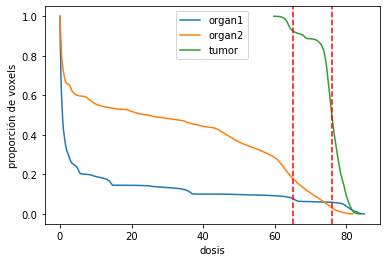

In [60]:
instance = imrt.imrt("/home/iaraya/imrt", ["data/TRT00X/TRT004_00b.txt", "data/TRT00X/TRT004-coord.txt"], ssh, max_voxels=2000000, port=8051, targeted=True)
instance.init_fluence_map(fluence_map=[14,14,19,14,14,14,14,20,14,14,14,14,20,14,14,16,16,20,16,16,16,16,20,17,17,17,17,20,16,16,17,17,20,16,17,14,10,0,7,7,5,8,8,8,8,6,6,13,8,8,6,6,13,10,10,6,6,13,10,10,8,8,5,5,5,5,10,5,5,8,11,14,10,8,8,12,8,8,8,8,11,11,8,8,8,8,14,8,8,8,8,14,8,8,8,8,14,9,9,8,8,11,11,12,19,16,16,20,15,15,13,13,15,13,13,13,13,16,13,13,13,13,16,15,15,15,15,18,16,16,15,13,20,18,15,13,20,16,13,0,5,5,5,5,5,17,7,7,10,10,17,7,7,10,10,17,10,10,10,10,17,10,10,10,10,14,10,14,10,10,5,0], \
                          bac=[0, 70, 140, 210, 280])
dose_vectors = instance.get_dose_vectors()
imrt.show_dvh(dose_vectors)

In [ ]:
instance = imrt.imrt("/home/iaraya/imrt", ["data/TRT00X/TRT005_10b.txt", "data/TRT00X/TRT005-coord.txt"], ssh, max_voxels=2000000, port=8051, targeted=True)

----
init_fluence_map
--

Carga el fluence map con el BAC (beam angle configuration) asociado.
Retorna la evaluación correspondiente.

In [33]:
instance.init_fluence_map(fluence_map=[9,12,10,13,11,11,10,10,10,10,12,11,11,11,10,10,10,10,12,12,12,11,10,9,9,9,10,12,11,10,10,10,9,9,11,11,11,9,9,9,9,9,9,9,9,9,9,11,11,13,11,10,10,10,13,13,12,11,11,12,12,13,13,13,13,13,13,0,5,5,9,5,9,8,8,8,5,0,9,8,8,8,7,7,5,5,8,8,9,9,8,8,8,8,5,9,9,9,8,8,8,8,5,7,8,9,9,9,9,0,5,9,9,9,9,8,9,9,9,9,9,7,7,7,9,6,6,5,9,5,13,12,11,10,13,12,12,10,13,13,12,12,12,13,13,13,13,12,12,12,13,13,12,12,12,11,11,11,13,11,11,11,11,11,9,9,10,12,10,10,10,10,10,9,13,13,12,12,11,11,10,10,13,12,12,12,12,11,11,10,11,11,11,13,13,10,10,10,10,13,11,11,11,2,2,10,0,8,10,10,2,2,12,12,13,0,11,13,13,13,8,8,12,13,13,13,12,10,13,13,13,13,13,11,10,12,12,12,13,13,12,8,8,11,11,11,12,13,10,0,11,11,11,11,13,8,13,10,10,0,0,0,12,12,12,12,12,12,12,11,11,11,11,12,9,9,9,12,11,9,9,9,11,11,8,8,8,9,9,9,12,12,8,9,9,9,10,11,12,10,9,10,10,10,12,11,10,9,11,11,11,12,12,11,10,10,10,10,11,11,12,11,11,11,11,11,11,11,11,12,12,10,12,9,9], bac=[50, 120, 190, 260, 330])

echo init_fluence_map 5 50 120 190 260 330 9 12 10 13 11 11 10 10 10 10 12 11 11 11 10 10 10 10 12 12 12 11 10 9 9 9 10 12 11 10 10 10 9 9 11 11 11 9 9 9 9 9 9 9 9 9 9 11 11 13 11 10 10 10 13 13 12 11 11 12 12 13 13 13 13 13 13 0 5 5 9 5 9 8 8 8 5 0 9 8 8 8 7 7 5 5 8 8 9 9 8 8 8 8 5 9 9 9 8 8 8 8 5 7 8 9 9 9 9 0 5 9 9 9 9 8 9 9 9 9 9 7 7 7 9 6 6 5 9 5 13 12 11 10 13 12 12 10 13 13 12 12 12 13 13 13 13 12 12 12 13 13 12 12 12 11 11 11 13 11 11 11 11 11 9 9 10 12 10 10 10 10 10 9 13 13 12 12 11 11 10 10 13 12 12 12 12 11 11 10 11 11 11 13 13 10 10 10 10 13 11 11 11 2 2 10 0 8 10 10 2 2 12 12 13 0 11 13 13 13 8 8 12 13 13 13 12 10 13 13 13 13 13 11 10 12 12 12 13 13 12 8 8 11 11 11 12 13 10 0 11 11 11 11 13 8 13 10 10 0 0 0 12 12 12 12 12 12 12 11 11 11 11 12 9 9 9 12 11 9 9 9 11 11 8 8 8 9 9 9 12 12 8 9 9 9 10 11 12 10 9 10 10 10 12 11 10 9 11 11 11 12 12 11 10 10 10 10 11 11 12 11 11 11 11 11 11 11 11 12 12 10 12 9 9 | netcat localhost 8051


61.9835

In [31]:
instance.local_search(type="beam_intensity",maxeval=5000)

(96.1853, 228)

### impact_map

Matrices de impacto para los beamlets

In [13]:
imap = instance.get_impact_map()
sum_=0; 
for i in imap: sum_ += len(i)
print(sum_)
fm = instance.get_fluence_map()
-np.sort(-fm[2])[0:5]
#i=2; instance.fm2matrix(imap[i],instance.bac[i], dtype=float)

218


array([16, 14,  5,  5,  5])

[5 5 5 5 5]


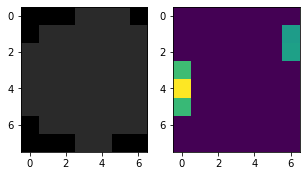

10142.5 1
[6 5 5 5 5]


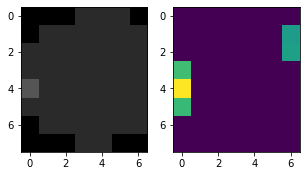

10132.0 2
[7 5 5 5 5]


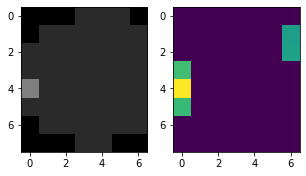

10121.6 3
[8 5 5 5 5]


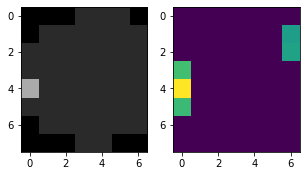

10111.3 4
[9 5 5 5 5]


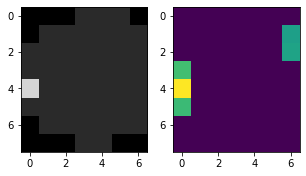

10101.2 5
[10  5  5  5  5]


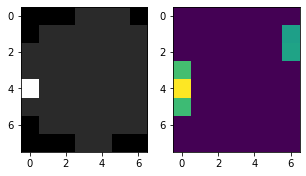

10091.1 6
[11  5  5  5  5]


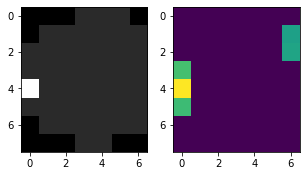

10081.2 7
[12  5  5  5  5]


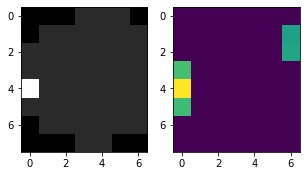

10071.4 8
[13  5  5  5  5]


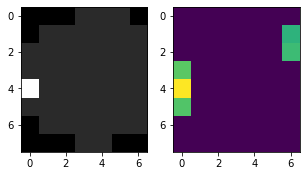

10061.8 9
[14  5  5  5  5]


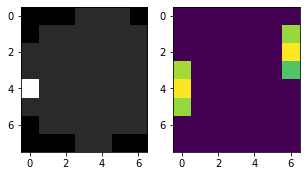

10039.8 10
[14  7  5  5  5]


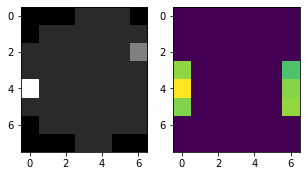

10030.3 11
[15  7  5  5  5]


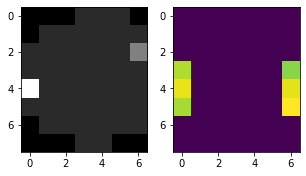

10019.3 12
[15  7  5  5  5]


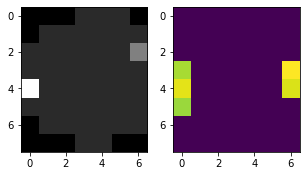

10006.2 13
[15  7  5  5  5]


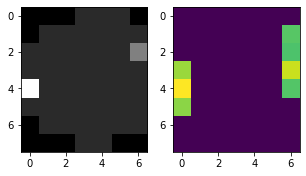

9996.81 14
[16  7  5  5  5]


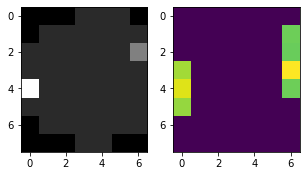

9971.21 15


In [27]:
#https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image as im 
%matplotlib inline

itt=0
for i in range(15):
    fm = instance.get_fluence_map()
    
    fig=plt.figure(figsize=(5, 5))

    i=3
    for angle in [instance.bac[2]]: #instance.bac:
        array = instance.fm2matrix(fm[i-1],angle)
        print(-np.sort(-fm[i-1])[0:5])
        fig.add_subplot(1, 2, 1) #2*len(instance.bac), i)
        plt.imshow(array, cmap="gray",vmin=4, vmax=10)
        i += 1

    #plt.show()
    
    imap = instance.get_impact_map()


    
    #fig=plt.figure(figsize=(8, 4))

    i=3
    for angle in [instance.bac[2]]: # instance.bac:
        array = instance.fm2matrix(imap[i-1],angle, dtype=float)
        fig.add_subplot(1, 2, 2)# 2*len(instance.bac), i+len(instance.bac))
        plt.imshow(array)
        i += 1
        
    ev, it = instance.local_search(type="beam_intensity",maxeval=1)
    itt += it
    plt.show()
    print(ev, itt)
    


----
iterated_local_search (`DAO_ILS`)
---

Realiza una búsqueda local usando dos vecindarios y retorna la evaluación de la solución encontrada (y la cantidad de iteraciones realizada). Usa los siguientes tipos de movimiento:

* *beam_intensity move*: modifica un beamlet de un fluence map matrix (existe la opción *targeted* para ordenar los movimientos)
* *level_intensity move*: modifica un nivel de intensidad de la matriz

In [281]:
ev = instance.local_search(type="beam_intensity",maxeval=5)

----
get_fluence_map
--
Retorna la solución del problema (fluence map vector)

In [29]:
fm = instance.get_fluence_map()

In [381]:
print(len(fm[0]), len(fm[1]), len(fm[2]))
len(fm[0]) + len(fm[1]) + len(fm[3]) + len(fm[4]) + len(fm[2])

43 44 45


218

In [382]:
fm[2]

array([10, 10, 11, 10, 10, 10, 10, 11, 11, 11, 11,  9,  9,  9,  9,  9, 10,
        9,  9,  9,  9,  9,  7, 10,  9,  9,  9,  9,  7,  7, 11,  9,  9,  5,
        5,  5,  5, 11, 11,  9,  9,  9,  5,  0,  0])

----
fm2matrix
--

Obtiene la matriz de intensidades de un ángulo a partir del *fluence map vector*.

In [383]:
Y = instance.fm2matrix(fm[0], 50)

En el siguiente ejemplo se grafica la matriz de intensidades para cada ángulo en el bac.

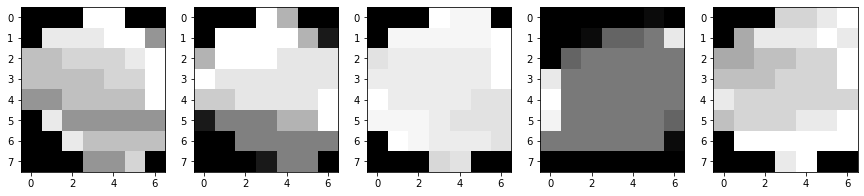

In [30]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image as im 

%matplotlib inline
fig=plt.figure(figsize=(15, 10))

i=1
for angle in instance.bac:
    array = instance.fm2matrix(fm[i-1],angle)
    fig.add_subplot(1, len(instance.bac), i)
    plt.imshow(array,cmap='gray')
    i += 1

plt.show()

----
get_dose_vectors
--

Retorna un vector de dosis irradiada a cada órgano por la solución (fluence map) actual.

In [34]:
dose_vectors = instance.get_dose_vectors()
for v in dose_vectors:
    print(v.shape)

(19762,)
(8500,)
(13081,)


Aquí obtenemos un gráfico que muestra la proporción de voxels (y) que recibe al menos una dosis x.
Dosis prescrita para el tumor: 76 
Dosis recomendada para los órganos: menos a 65

<module 'matplotlib.pyplot' from 'C:\\Users\\Dell\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

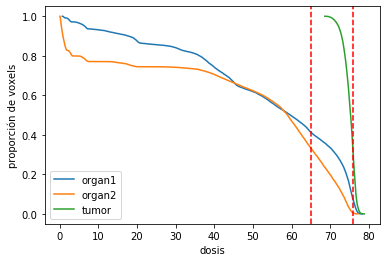

In [37]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image as im 

dose_vectors[0][::-1].sort()
index0 = (np.arange(len(dose_vectors[0]))+1)/len(dose_vectors[0])
dose_vectors[1][::-1].sort()
index1 = (np.arange(len(dose_vectors[1]))+1)/len(dose_vectors[1])
dose_vectors[2][::-1].sort()
index2 = (np.arange(len(dose_vectors[2]))+1)/len(dose_vectors[2])
plt.xlabel('dosis')
plt.ylabel('proporción de voxels')
plt.plot(dose_vectors[0], index0, '-' , dose_vectors[1], index1, '-' ,dose_vectors[2], index2, '-')
plt.axvline(x=65, color='r', linestyle='--')
plt.axvline(x=76, color='r', linestyle='--')
plt.legend(['organ1', 'organ2', 'tumor'], loc='best')
plt

Indicadores clínicos
----

- $D_{x}$: Dosis recibida por el x% del tumor/órgano
- $D_{max}$: Máxima dosis recibida por el tumor/órgano
- $D_{mean}$: Dosis promedio recibida por el tumor/órgano
- $V_{x}$: Voxels que reciben al menos x% de la dosis

In [41]:
def D(dose_vector, x=95): return dose_vector[int(len(dose_vector)*x/100)]
def Dmax(dose_vector): return np.max(dose_vector)
def Dmean(dose_vector): return np.mean(dose_vector)
def V(dose_vector, dose=0.95*76): return np.argmax(dose_vector < dose)/len(dose_vector)

print("D_95 (tumor): ", D(dose_vectors[2],x=95))
print("Dmax (organ1): ", Dmax(dose_vectors[0]))
print("Dmean (organ2): ", Dmean(dose_vectors[1]))
print("V_95 (tumor): ", V(dose_vectors[2], dose=0.99*76))

D_95 (tumor):  68.023
Dmax (organ1):  83.3628
Dmean (organ2):  51.5255664
V_95 (tumor):  0.288


---
Otras funcionalidades
---

**matrix2fm**

Pasa una matrix a fluence_map asociado a un ángulo.

Note que si el angulo es distinto al original, el resultado puede no ser válido.

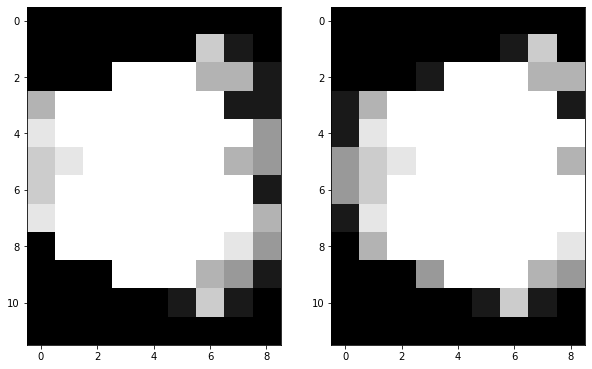

In [45]:
fig=plt.figure(figsize=(10, 10))


Y = instance.fm2matrix(fm[0],5)
fig.add_subplot(1, 2, 1)
plt.imshow(array,cmap='gray')

fm_new = instance.matrix2fm(Y, 0) # ángulo original es 0 y cambió a 5
fm[0] = fm_new
array = instance.fm2matrix(fm_new,5)
fig.add_subplot(1, 2, 2)
plt.imshow(array,cmap='gray')

plt.show()

Para llamar a la función `init_fluence_map` con una lista de fluence maps, tenemos que concatenarlas así `np.concatenate(tuple(fluence_maps)`

In [43]:
instance.init_fluence_map(np.concatenate(tuple(fm)), bac=[5, 175, 245, 315])

echo init_fluence_map 4 5 175 245 315 7 0 9 9 9 6 6 0 6 9 9 9 9 9 9 0 0 8 9 9 9 9 9 9 9 5 7 8 9 9 9 9 9 6 5 7 9 9 9 9 9 9 9 0 8 9 9 9 9 9 9 9 6 9 9 9 9 9 9 8 5 9 9 9 6 5 0 0 7 0 5 17 21 21 21 20 20 17 5 17 21 21 20 17 17 5 5 21 21 21 17 17 17 17 17 0 17 17 17 17 17 20 21 20 17 21 21 21 21 17 17 17 17 0 17 17 17 17 17 17 20 5 5 11 11 11 17 17 20 21 0 0 21 21 20 20 17 17 17 5 0 0 5 5 10 12 12 0 0 0 0 0 5 12 13 13 0 0 14 14 14 12 12 10 5 5 5 10 12 13 13 13 14 14 0 0 5 14 14 10 10 10 10 10 0 14 14 13 13 10 10 10 10 5 5 14 14 14 12 10 10 10 0 10 10 5 0 0 5 10 5 5 0 10 0 0 5 5 15 15 14 14 13 10 5 15 15 15 13 13 10 10 10 10 10 10 10 10 10 10 15 15 10 14 14 15 15 15 14 14 14 10 13 13 13 13 13 13 15 15 10 14 14 14 15 15 15 15 13 14 15 15 15 | netcat localhost 8051


128.493

Note que al comenzar de un buen fluence map para un ángulo vecino, la búsqueda local converge mucho más rápido:

In [44]:
instance.iterated_local_search(maxeval=1000)

(43.2106, 1000)

---
**get_deposition_matrix**

Sea $M$ una matriz de deposición para un órgano $organ$ y ángulo $angle$.

$M[k][b]$ indica la dosis irradiada por un beamlet $b$ del ángulo $angle$ en el voxel $k$ del órgano $organ$.

In [15]:
M = instance.get_deposition_matrix(2, 0)

Se imprimen la dosis a los voxels vs los beamlets (se ordenan los beamlets desde el que causa mayor impacto)

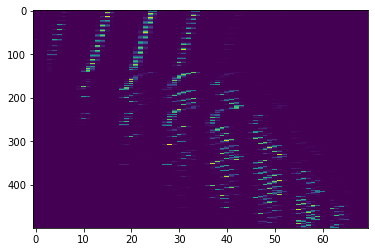

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.ion()
plt.imshow(M,interpolation='none', aspect='auto')

In [17]:
M[76,0] # impacto del beamlet 0 en el voxels 76

0.00211954

In [18]:
np.argsort(-M[:,0])[0:20] #voxels más impactado por beamlet 0

array([55, 67, 22, 44, 33, 68, 56, 91, 45, 23, 34, 57, 46, 80, 69, 13, 24,
       35, 92, 81], dtype=int64)

In [19]:
np.argsort(-M[76,:])[0:20] #beamlets con mayor impacto en voxel 76

array([22, 31, 23, 32, 30, 21, 13, 14, 24, 39, 12, 15, 50, 34, 25, 11, 43,
       52,  7, 26], dtype=int64)